# Personalised recommendations to increase AOV of Instacart loyalists
---

## Part 2: EDA and data pruning

In this notebook, I will do an exploratory analysis of the data and prune the dataset to a more manageable size for building our recommender systems (RecSys) in Part 5.

---

### Load libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_style('darkgrid')
import squarify
import matplotlib
from IPython.display import display

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
# load merged datasets from Part 1
products_df = pd.read_pickle('../datasets/products_df.pkl')
df = pd.read_pickle('../datasets/full_combined_df.pkl')

### Summary of all datasets

In [3]:
# function to retrieve the name of each dataframe
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# for printing out customised summary of each dataframe
df_list = [products_df, df]
for df in df_list:
    print('---------------------------------------------------------------------------')
    print('Dataset:          ', get_df_name(df)) # prints out `name` of df returned from get_df_name() function
    print('Dimensions:       ', '{:,}'.format(df.shape[0]), 'rows,', df.shape[1], 'columns')
    print('Null values:      ', df.isnull().sum().sum())
    print('Columns with null:', df.columns[df.isnull().any()].tolist()) # df.isnull().any() returns boolean values
    display(df.head(3))
#     print('Datatypes:')
#     print(df.dtypes, '\n')

---------------------------------------------------------------------------
Dataset:           products_df
Dimensions:        49,688 rows, 6 columns
Null values:       0
Columns with null: []


,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes


---------------------------------------------------------------------------
Dataset:           df
Dimensions:        33,819,106 rows, 12 columns
Null values:       2078068
Columns with null: ['days_since_prior_order']


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,department,aisle
0,2539329,1,1,2,8,NaN,196,1,0,Soda,beverages,soft drinks
1,2398795,1,2,3,7,15.0,196,1,1,Soda,beverages,soft drinks
2,473747,1,3,3,12,21.0,196,1,1,Soda,beverages,soft drinks


**Description of datasets**

`products_df`
- Contains product name, aisle, and department information for each product
- Each row represents a unique product, which means there are 49,688 unique products in the dataset

`df`
- Each row represents a product within an order. An order containing _n_ products will have _n_ rows
- There are 33,819,106 products ordered in total
- Product details include product id, order in which the product was added to cart, and whether the product is a reorder

## Exploratory Data Analysis

### ------- Overview stats -------

#### Number of customers and orders

In [4]:
cust_count = df.user_id.nunique()
order_count = df.order_id.nunique()
print(f'{cust_count:,} customers made a total of {order_count:,} orders.')

206,209 customers made a total of 3,346,083 orders.


#### Number of products, aisles, and departments

In [5]:
# the rows in `products` are non-duplicates so we can do a .count() to get number of unique products
product_count = products_df.product_name.count()
print(f'There are {product_count:,} unique products.')

There are 49,688 unique products.


In [6]:
dept_count = products_df.department_id.nunique()
aisle_count = products_df.aisle_id.nunique()
print(f'There are {dept_count:,} departments, sub-categorised into {aisle_count} aisles.')

There are 21 departments, sub-categorised into 134 aisles.


### ------- Reorders ------- 

#### What proportion of purchases are reorders?

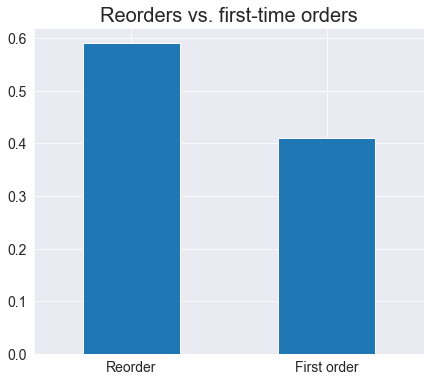

In [7]:
fig, ax = plt.subplots(figsize=(7,6))
ax = df.reordered.value_counts(normalize=True).plot(kind='bar')
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.tick_params(axis='y', labelsize=14)
ax.set_xticklabels(['Reorder', 'First order'], fontsize=14, rotation=0)
ax.set_title('Reorders vs. first-time orders', fontsize=20);

- 59% of all products ordered are reorders.

#### Which items are reordered the most? (absolute count)

In [8]:
# reorder count and total sales volume of every product
reorder_rate = df.groupby('product_name').agg(reorder_count=('reordered', 'sum'),
                                              sales_vol=('order_id', 'count'))\
                                        .sort_values('reorder_count', ascending=False).reset_index().head(50)

In [9]:
reorder_rate['reorder_rate'] = reorder_rate['reorder_count'] / reorder_rate['sales_vol'] 

# products with the highest reorder rates
reorder_rate = reorder_rate.sort_values('reorder_rate', ascending=False).head(20)

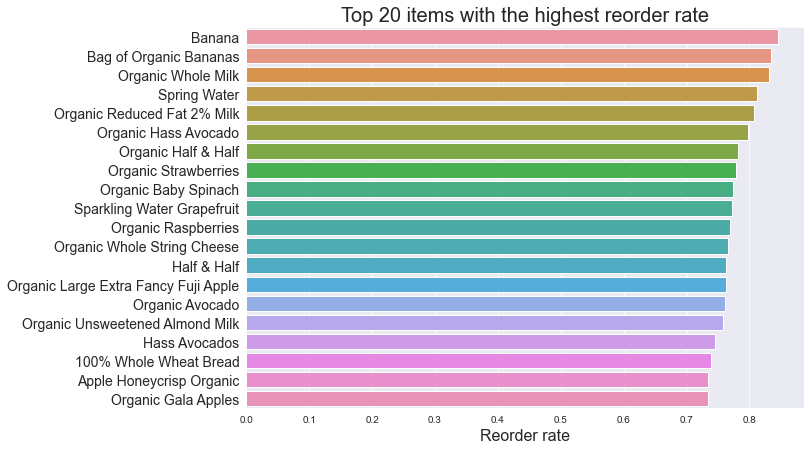

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.barplot(x='reorder_rate', y='product_name', data=reorder_rate[:20])
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel('Reorder rate', fontsize=16)
ax.set_ylabel(None)
ax.set_title('Top 20 items with the highest reorder rate', fontsize=20);

### ------- Analysis by order ------- 


#### Order frequency by Day of Week and Hour of Day

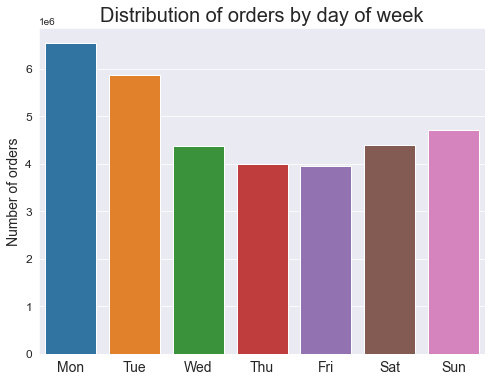

In [11]:
# distribution of orders by day of week
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.countplot(x='order_dow', data=df) # , color='darkseagreen'
ax.set_xlabel(None)
ax.set_ylabel('Number of orders', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=14, rotation=0)
ax.set_title('Distribution of orders by day of week', fontsize=20);

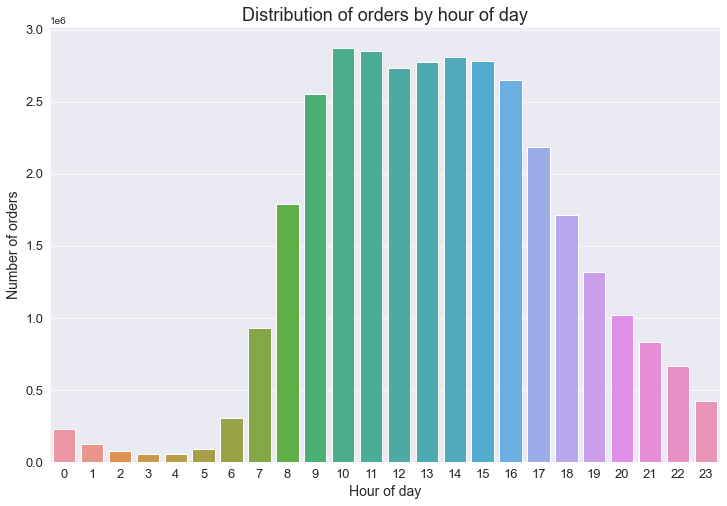

In [12]:
# distribution of orders by hour of day
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='order_hour_of_day', data=df)
ax.set_xlabel('Hour of day', fontsize=14)
ax.set_ylabel('Number of orders', fontsize=14)
ax.tick_params(labelsize=13)
ax.set_title('Distribution of orders by hour of day', fontsize=18);

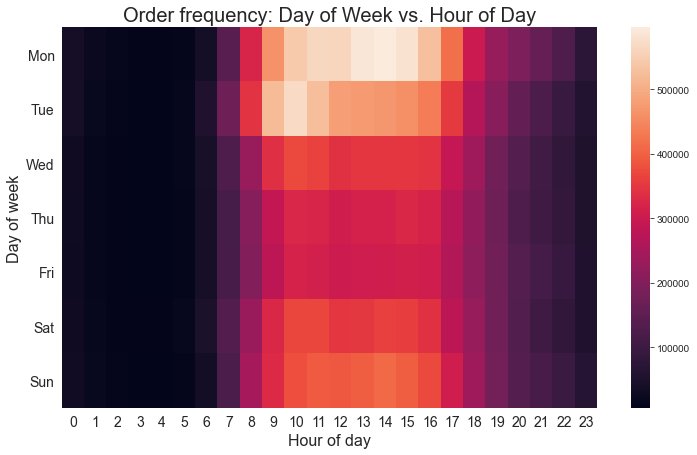

In [13]:
# pivot table of orders by DAY OF WEEK / HOUR OF DAY
orders_dow_hour = df.groupby(['order_dow', 'order_hour_of_day']).agg(order_count=('order_id', 'count')).unstack()

# heatmap of orders by DAY OF WEEK / HOUR OF DAY
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.heatmap(orders_dow_hour)
# It is assumed the week starts on Monday (denoted by 0) and ends on Sunday (denoted by 6).
ax.set_xlabel('Hour of day', fontsize=16)
ax.set_xticklabels(sorted(df['order_hour_of_day'].unique()), fontsize=14, rotation=0)
ax.set_ylabel('Day of week', fontsize=16)
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=14, rotation=0)
ax.set_title('Order frequency: Day of Week vs. Hour of Day', fontsize=20);

#### Number of days between orders

In [14]:
# create a temporary orders df for plotting. keep only rows where days_since_prior_order is not NA.
temp_orders = df.loc[df.days_since_prior_order.notna()].copy()
temp_orders['days_since_prior_order'] = temp_orders['days_since_prior_order'].astype(int)

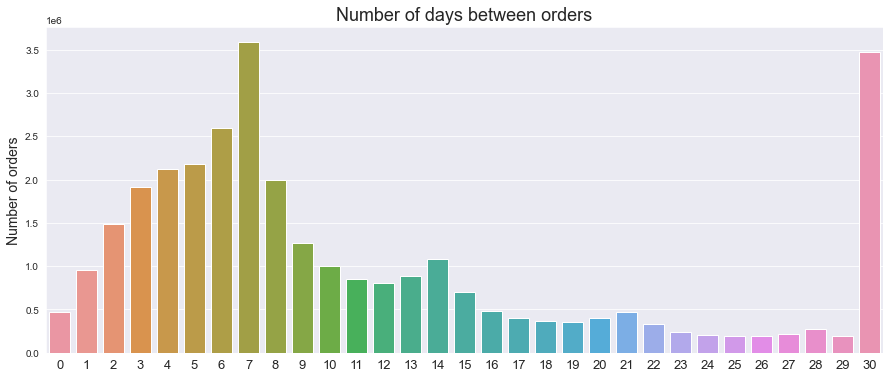

In [15]:
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.countplot(x='days_since_prior_order', data=temp_orders)
ax.tick_params(axis='x', rotation=0, labelsize=13)
ax.set_xlabel(None)
ax.set_ylabel('Number of orders', fontsize=14)
ax.set_title('Number of days between orders', fontsize=18);

- Loyal customers have a weekly purchase cycle, as seen from the uptrend in number of orders at days=7, with a steep decline thereafter on day 8.
- Infrequent customers are represented by the large number of orders at days=30. (Note: the number of days between orders is capped at 30, so values above 30 are consolidated at days=30 as well)

#### Distribution of orders by order size

In [16]:
# find the total number of products in each order
grouped_df = df.groupby("order_id")["add_to_cart_order"].max().reset_index()
grouped_df.rename(columns={'add_to_cart_order': 'order_size'}, inplace=True)
grouped_df

,order_id,order_size
0,1,8
1,2,9
2,3,8
3,4,13
4,5,26
...,...,...
3346078,3421079,1
3346079,3421080,9
3346080,3421081,7
3346081,3421082,7


In [17]:
cnt_srs = grouped_df.order_size.value_counts()

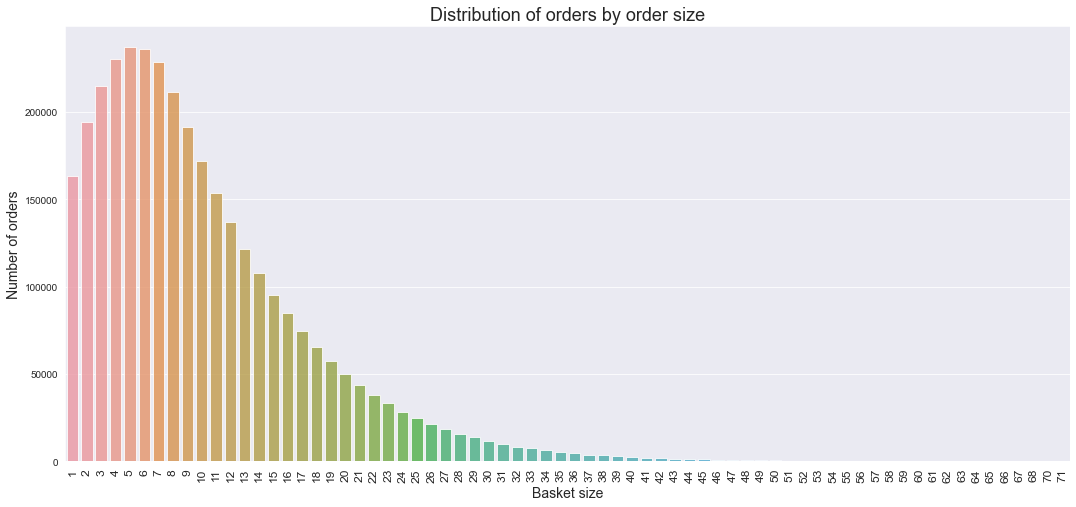

In [18]:
# plot the distribution of orders by order size
fig, ax = plt.subplots(figsize=(18,8))
ax = sns.barplot(cnt_srs.index[:70], cnt_srs.values[:70], alpha=0.8)
ax.tick_params(axis='x', rotation=90, labelsize=12)
ax.set_ylabel('Number of orders', fontsize=14)
ax.set_xlabel('Basket size', fontsize=14)
ax.set_title('Distribution of orders by order size', fontsize=18);

- An order size of 5 or 6 items is the most common. The small orders could be made by customers who purchase regularly from Instacart, but at small amounts each time. These customers could mainly be getting fresh produce, and thus prefer to buy in small quantities each time for maximum freshness. 

#### Average order size of customers

In [19]:
# view average number of items per order (average order size)
# `df.groupby(level=0)` specifies the first index of the Dataframe. 
user_order_size = round(df.groupby(['user_id', 'order_id']).agg(order_size=('product_id', 'count')).groupby(level=0).mean(), 2)
user_order_size

,order_size
user_id,
1,6.36
2,15.07
3,7.33
4,3.60
5,9.20
...,...
206205,12.75
206206,4.25
206207,13.94


In [20]:
# average order size of each customer
user_order_size.mean()

order_size    9.984529
dtype: float64

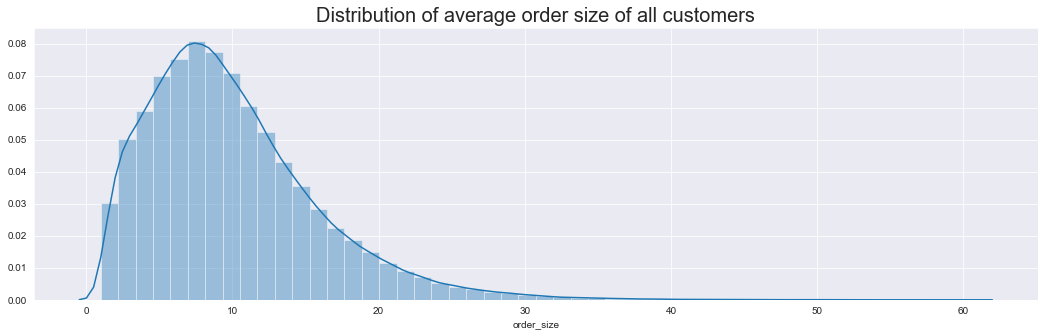

In [21]:
# distribution of all customers' average order size
fig, ax = plt.subplots(figsize=(18, 5))
ax = sns.distplot(user_order_size['order_size'])
ax.set_title('Distribution of average order size of all customers', fontsize=20);

### ------- Analysis by customer ------- 

#### Total orders per customer

In [22]:
# find the total number of orders for each customer (represented by the max value of `order_number`)
total_orders = df.groupby('user_id').agg(total_orders=('order_number', 'max')).reset_index()

In [23]:
total_orders

,user_id,total_orders
0,1,11
1,2,15
2,3,12
3,4,5
4,5,5
...,...,...
206204,206205,4
206205,206206,67
206206,206207,16
206207,206208,49


In [25]:
# group by total orders and count the number of customers in each group
total_orders_grp = total_orders.groupby('total_orders').count().reset_index()
total_orders_grp.columns = ['total_orders', 'number_of_customers']
total_orders_grp

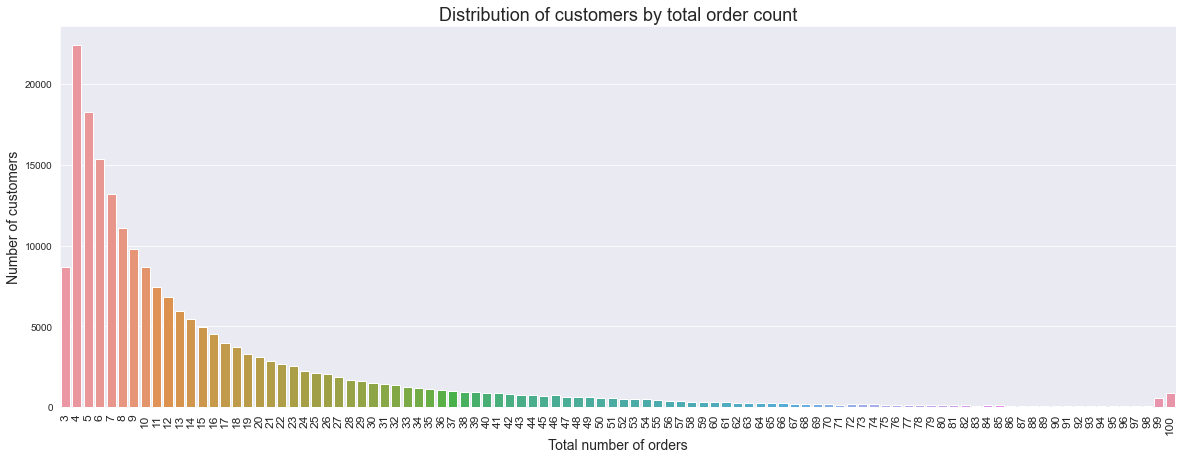

In [26]:
# plot the distribution of customers by total order count
fig, ax = plt.subplots(figsize=(20,7))
ax = sns.barplot(total_orders_grp.total_orders, total_orders_grp.number_of_customers)
ax.tick_params(axis='x', rotation=90, labelsize=12)
ax.set_ylabel('Number of customers', fontsize=14)
ax.set_xlabel('Total number of orders', fontsize=14)
ax.set_title('Distribution of customers by total order count', fontsize=18);

In our dataset, the maximum number of total orders per customer is capped at 100, and the minimum total orders is 3.

Percentage of customer base who made:

- 100 orders: 867 customers (0.42% of all customers)
- 3 orders: 8686 customers (4.21% of all customers)

### ------- Analysis by product ------- 

#### Top products by sales volume

In [27]:
# get total sales volume and total unique customers for each product
products_sales = df.groupby(['product_name', 'product_id'])\
                  .agg(sales_vol=('order_id', 'count'),
                       users_bought=('user_id', 'nunique'))\
                    .sort_values('sales_vol', ascending=False).reset_index()

In [28]:
# calculate the average sales volume per user for each product
products_sales['vol_per_user'] = products_sales['sales_vol'] / products_sales['users_bought']

In [29]:
# add department column to df 
products_sales = products_sales.merge(products_df[['product_name', 'department']], on='product_name', how='left')

In [30]:
products_sales

,product_name,product_id,sales_vol,users_bought,vol_per_user,department
0,Banana,24852,491291,76125,6.453741,produce
1,Bag of Organic Bananas,13176,394930,65655,6.015231,produce
2,Organic Strawberries,21137,275577,61129,4.508122,produce
3,Organic Baby Spinach,21903,251705,56766,4.434080,produce
4,Organic Hass Avocado,47209,220877,44704,4.940878,produce
...,...,...,...,...,...,...
49680,Greek Blended Cherry Fat Free Yogurt,1908,1,1,1.000000,dairy eggs
49681,All Natural Stevia Liquid Extract Sweetener,1002,1,1,1.000000,pantry
49682,"Frittata, Farmer's Market",14756,1,1,1.000000,frozen
49683,Max White With Polishing Star Soft Toothbrush,26627,1,1,1.000000,personal care


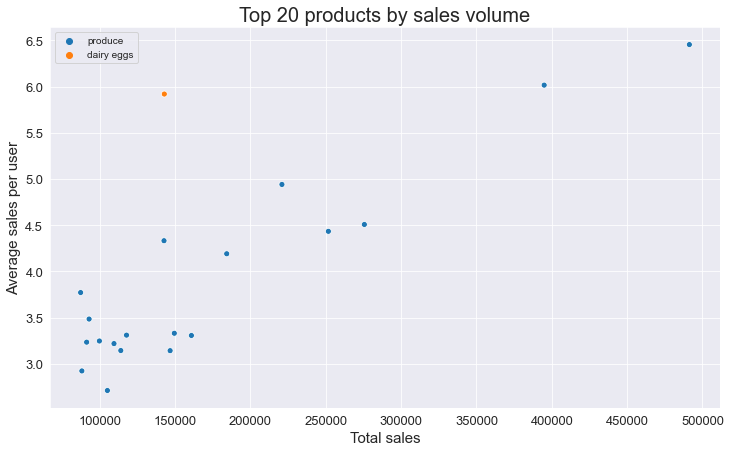

In [36]:
# top 20 products by sales volume
dept_hue = [str(d) for d in products_sales.department][:20]
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x=products_sales.sales_vol[:20], y=products_sales.vol_per_user[:20], data=products_sales[:20], hue=dept_hue)
ax.set_title('Top 20 products by sales volume', fontsize=20)
ax.tick_params(labelsize=13)
ax.set_ylabel('Average sales per user', fontsize=15)
ax.set_xlabel('Total sales', fontsize=15);

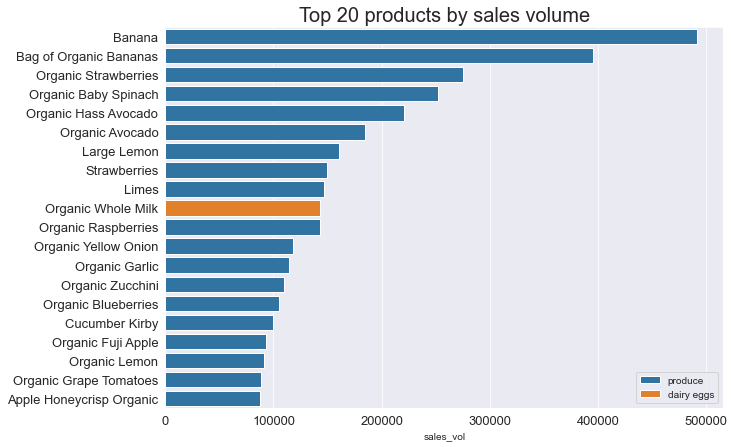

In [38]:
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.barplot(x=products_sales.sales_vol[:20], y=products_sales.product_name[:20], data=products_sales[:20], hue=dept_hue, dodge=False)
ax.set_title('Top 20 products by sales volume', fontsize=20)
ax.tick_params(labelsize=13)
ax.set_ylabel(None);

- Organic items are highly popular and make up 14 out of the top 20 items.
- Majority of the items are fresh produce that are commonly consumed on a weekly basis, which could be why they have the highest sales volume.
- Only Organic Whole Milk is not from the produce section, but it is also a regularly consumed item for many people, which explains its popularity.

#### Quantiles of sales volume

In [50]:
pd.DataFrame(products_sales.sales_vol.quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9]))

,sales_vol
0.1,8.0
0.2,14.0
0.3,23.0
0.4,38.0
0.5,63.0
0.6,106.0
0.7,194.0
0.8,393.0
0.9,1066.0


### ------- Analysis by department ------- 

#### Shelf space by department

In [51]:
# number of unique items in each department
dept_grouped = products_df.groupby('department').agg(product_count=('product_id', 'nunique')).\
               sort_values('product_count', ascending=False)

In [52]:
dept_grouped['pct'] = round(dept_grouped['product_count'] / dept_grouped['product_count'].sum() * 100, 1)

In [53]:
dept_grouped

,product_count,pct
department,,
personal care,6563,13.2
snacks,6264,12.6
pantry,5371,10.8
beverages,4365,8.8
frozen,4007,8.1
dairy eggs,3449,6.9
household,3085,6.2
canned goods,2092,4.2
dry goods pasta,1858,3.7


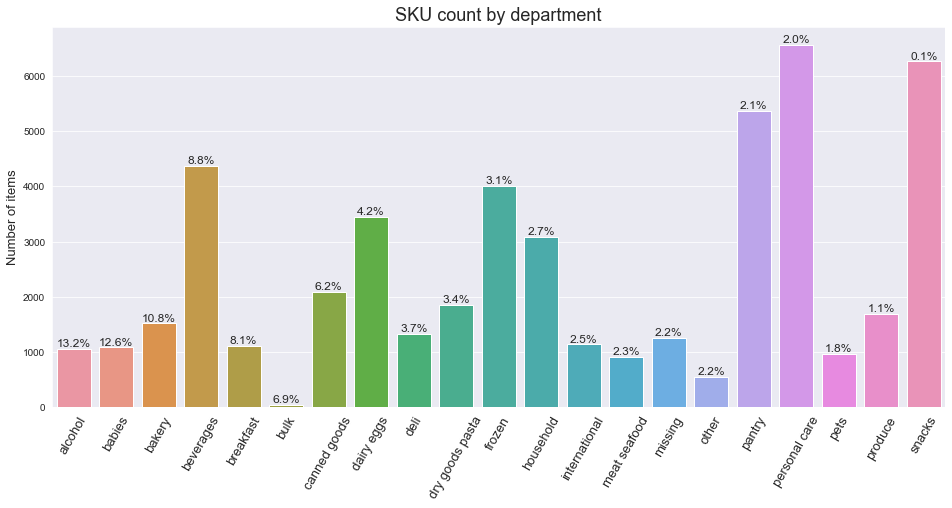

In [54]:
# barplot of distribution of unique items by department
fig, ax = plt.subplots(figsize=(16,7))
ax = sns.barplot(dept_grouped.index, dept_grouped.product_count)
ax.tick_params(axis='x', rotation=60, labelsize=13)
ax.set_ylabel('Number of items', fontsize=13)
ax.set_xlabel(None)
ax.set_title('SKU count by department', fontsize=18)

labels = [str(x) + '%' for x in dept_grouped['pct'].values]
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=12)  

#### Total sales by department

In [55]:
dept_sales = df.groupby(['department']).agg(amount_sold=('order_id', 'count'))\
                .sort_values('amount_sold', ascending=False).reset_index()

In [56]:
dept_sales['pct'] = round(dept_sales['amount_sold'] / dept_sales['amount_sold'].sum() * 100, 1)

In [57]:
dept_sales

,department,amount_sold,pct
0,produce,9888378,29.2
1,dairy eggs,5631067,16.7
2,snacks,3006412,8.9
3,beverages,2804175,8.3
4,frozen,2336858,6.9
5,pantry,1956819,5.8
6,bakery,1225181,3.6
7,canned goods,1114857,3.3
8,deli,1095540,3.2
9,dry goods pasta,905340,2.7


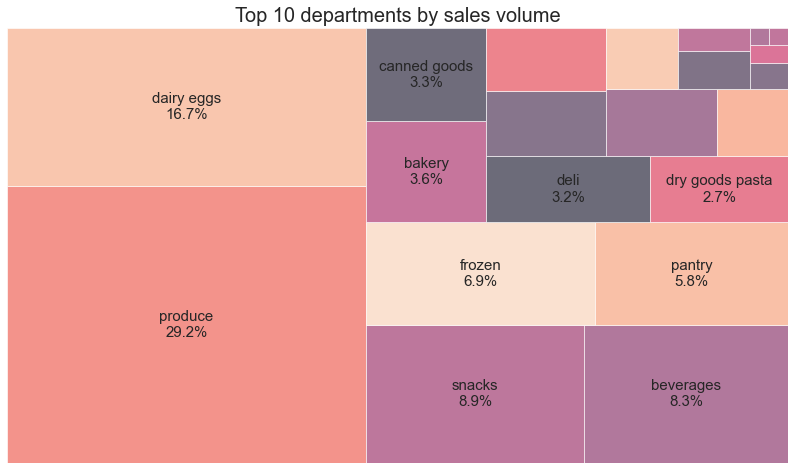

In [58]:
# labels for treemap
pdts = [p for p in dept_sales['department']]
perc = [str(i) for i in dept_sales['pct']]
lbl = [group[0] + "\n" + group[1] + '%' for group in zip(pdts, perc)]

# Utilise matplotlib to scale our pct values between the min and max, then assign this scale to our values.
norm = matplotlib.colors.Normalize(vmin=min(dept_sales['pct']), vmax=max(dept_sales['pct']))
colors = [matplotlib.cm.Spectral(norm(value)) for value in dept_sales['pct']]

# plot treemap
fig, ax = plt.subplots(1, figsize = (14,8))

squarify.plot(sizes=dept_sales['pct'], 
              label=lbl[:10],
              alpha=0.6,
#               color=colors,
              text_kwargs={'fontsize':15})
plt.title('Top 10 departments by sales volume', fontsize=20)
plt.axis('off');

In [59]:
# import plotly.express as px
# df_test = dept_sales
# df_test["All"] = "All" # in order to have a single root node
# fig = px.treemap(df_test, path=['All', 'department'], values='amount_sold')
# fig.show()

### ------- Analysis by aisle ------- 

#### Count of unique items by aisle

In [60]:
# number of unique items by aisle
aisle_grouped = products_df.groupby('aisle').agg(product_count=('product_id', 'count')).\
                sort_values('product_count', ascending=False)

In [61]:
aisle_grouped
# There are 134 aisles including `missing`, which has the highest product count.

,product_count
aisle,
missing,1258
candy chocolate,1246
ice cream ice,1091
vitamins supplements,1038
yogurt,1026
chips pretzels,989
tea,894
packaged cheese,891
frozen meals,880


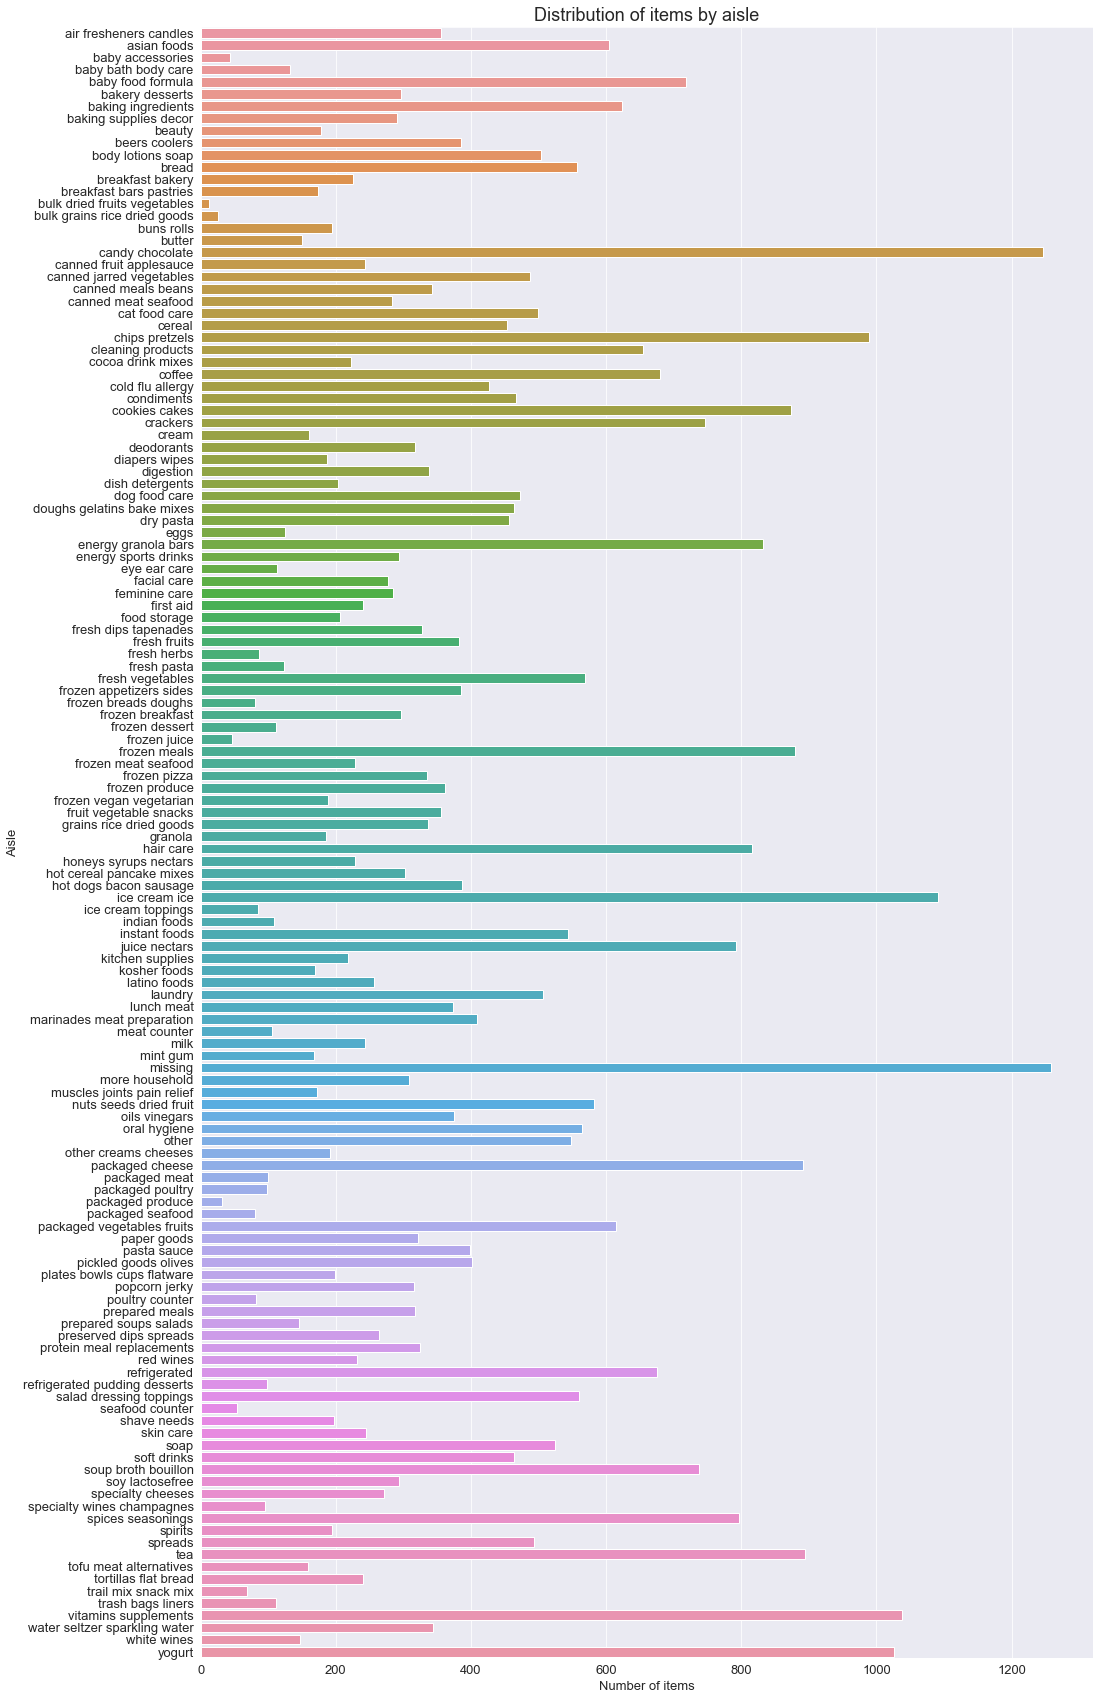

In [62]:
# distribution of items by aisle
plt.figure(figsize=(16,30))
sns.barplot(aisle_grouped.product_count, aisle_grouped.index, orient='h')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Aisle', fontsize=13)
plt.xlabel('Number of items', fontsize=13)
plt.title('Distribution of items by aisle', fontsize=18);

#### Total sales by aisle

In [63]:
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,department,aisle
0,2539329,1,1,2,8,NaN,196,1,0,Soda,beverages,soft drinks
1,2398795,1,2,3,7,15.0,196,1,1,Soda,beverages,soft drinks
2,473747,1,3,3,12,21.0,196,1,1,Soda,beverages,soft drinks
3,2254736,1,4,4,7,29.0,196,1,1,Soda,beverages,soft drinks
4,431534,1,5,4,15,28.0,196,1,1,Soda,beverages,soft drinks


#### Missing values in aisle and department

In [64]:
# investigate rows with missing department or aisle
products_df[(products_df['department'] == 'missing') | (products_df['aisle'] == 'missing')]

# The products that are missing a `department` value are also missing an `aisle` value.

,product_id,product_name,aisle_id,department_id,department,aisle
42813,38,Ultra Antibacterial Dish Liquid,100,21,missing,missing
42814,72,Organic Honeycrisp Apples,100,21,missing,missing
42815,110,Uncured Turkey Bologna,100,21,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",100,21,missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,100,21,missing,missing
...,...,...,...,...,...,...
44066,49553,Organic Plain Skyr,100,21,missing,missing
44067,49575,Chocolate Vanilla Malt Custard,100,21,missing,missing
44068,49641,"8\"" Pecan Pie",100,21,missing,missing
44069,49664,Lemon Cayenne Drinking Vinegar,100,21,missing,missing


#### Organic products

In [65]:
# add `organic` category to products df
products_df['organic'] = products_df['product_name'].apply(lambda x: 1 if 'organic' in x.lower() else 0)

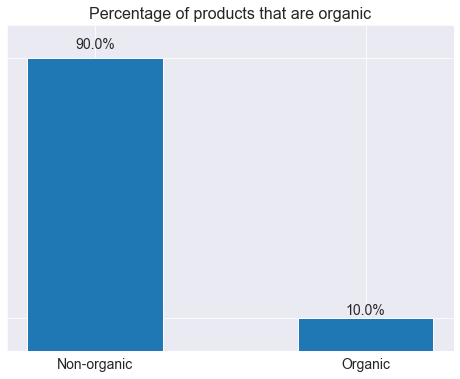

In [66]:
fig, ax = plt.subplots(figsize=(8,6))
bar_x = products_df['organic'].value_counts(normalize=True).index
bar_height = products_df['organic'].value_counts(normalize=True).values
bar_tick_label = ['Non-organic', 'Organic']
bar_label = [str(round(i, 2)*100)+'%' for i in products_df['organic'].value_counts(normalize=True).values]

bar_plot = plt.bar(bar_x, bar_height, tick_label=bar_tick_label, width=0.5)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0, fontsize=14)

autolabel(bar_plot)

plt.ylim(0, 1)
plt.yticks(bar_height, "")
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 14)
plt.title('Percentage of products that are organic', fontsize=16);

In [67]:
organic_count = products_df['organic'].sum()
normal_count = len(products_df)
print(f'There are {organic_count:,} ({round(organic_count/normal_count * 100, 2)}%) out of {normal_count:,} products that are organic.')

There are 5,036 (10.14%) out of 49,688 products that are organic.


In [68]:
# add `organic` category to full df
df['organic'] = df['product_name'].apply(lambda x: 1 if 'organic' in x.lower() else 0)

In [69]:
# sales of organic products
df['organic'].value_counts()

0    23162774
1    10656332
Name: organic, dtype: int64

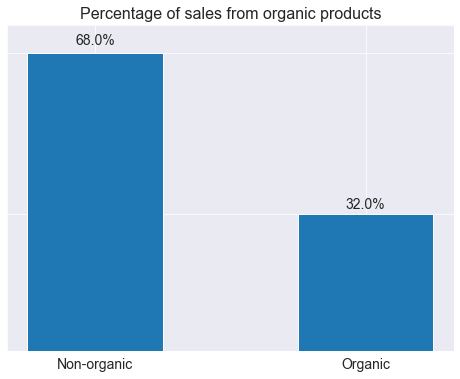

In [70]:
fig, ax = plt.subplots(figsize=(8,6))

bar_x = df['organic'].value_counts(normalize=True).index
bar_height = df['organic'].value_counts(normalize=True).values
bar_tick_label = ['Non-organic', 'Organic']
bar_label = [str(round(i, 2)*100)+'%' for i in df['organic'].value_counts(normalize=True).values]

bar_plot = plt.bar(bar_x, bar_height, tick_label=bar_tick_label, width=0.5)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0, fontsize=14)

autolabel(bar_plot)

plt.ylim(0, 0.75)
plt.yticks(bar_height, "")
ax = plt.gca()
ax.tick_params(axis = 'x', which = 'major', labelsize = 14)
plt.title('Percentage of sales from organic products', fontsize=16);

- Organic items only make up 10% of the dataset, but they contribute to 32% of overall sales volume.

#### Best-selling product in each department

In [71]:
# df.groupby(level=0)
# It specifies the first index of the Dataframe. When you have multiple indices 
# and you need to groupby only one index of those multiple indices of the dataframe we use it.

top_prod_dept = df.groupby(['department', 'product_name']).agg(order_count=('order_id', 'count'))\
                .sort_values('order_count', ascending=False).groupby(level=0).head(1)

In [72]:
top_prod_dept.sort_values('order_count', ascending=False).groupby(level=0).head(1)

,,order_count
department,product_name,
produce,Banana,491291
dairy eggs,Organic Whole Milk,142813
beverages,Sparkling Water Grapefruit,79245
deli,Original Hummus,74172
bakery,100% Whole Wheat Bread,63114
frozen,Blueberries,58269
meat seafood,Boneless Skinless Chicken Breasts,52369
pantry,Extra Virgin Olive Oil,52323
canned goods,Organic Black Beans,39577


## Drop rows from dataset

Building a recommendation system using the entire dataset would be a highly computationally intense job, so I will be pruning the dataset to a more manageable size:

1. Drop products that were ordered less than 150 times
2. Drop orders with less than 4 items
3. Keep only users who have made at least 20 orders, and we will only retain their 20 most recent orders

#### Drop products that were ordered less than 150 times

In [74]:
# dataframe created earlier containing sales volume of each product
products_sales

,product_name,product_id,sales_vol,users_bought,vol_per_user,department
0,Banana,24852,491291,76125,6.453741,produce
1,Bag of Organic Bananas,13176,394930,65655,6.015231,produce
2,Organic Strawberries,21137,275577,61129,4.508122,produce
3,Organic Baby Spinach,21903,251705,56766,4.434080,produce
4,Organic Hass Avocado,47209,220877,44704,4.940878,produce
...,...,...,...,...,...,...
49680,Greek Blended Cherry Fat Free Yogurt,1908,1,1,1.000000,dairy eggs
49681,All Natural Stevia Liquid Extract Sweetener,1002,1,1,1.000000,pantry
49682,"Frittata, Farmer's Market",14756,1,1,1.000000,frozen
49683,Max White With Polishing Star Soft Toothbrush,26627,1,1,1.000000,personal care


In [75]:
# products ordered less than 150 times
prods_to_drop = products_sales[products_sales['sales_vol'] <= 150]['product_id'].tolist()

In [78]:
# number of products being dropped
len(prods_to_drop)

32826

In [79]:
# drop the products from df
df_reduced = df[~df['product_id'].isin(prods_to_drop)]

In [81]:
# number of products left in our orders dataset
df_reduced.product_id.nunique()

16859

In [83]:
# drop the same products from the `products` dataframe
products_df_reduced = products_df[~products_df['product_id'].isin(prods_to_drop)]

In [85]:
# pickle the reduced products dataset for subsequent use
products_df_reduced.to_pickle('../datasets/products_df_reduced.pkl')

#### Drop orders with less than 4 items.

In [86]:
# get the total number of products in each order
orders = df_reduced[['order_id', 'product_id']].sort_values(['order_id', 'product_id']).set_index('order_id')['product_id']

In [93]:
# list of orders with less than 4 items to drop
orders_to_drop = orders[orders.index.value_counts() < 4].index

In [94]:
len(orders_to_drop) # number of orders to drop

1275459

In [96]:
# drop from orders dataset
df_reduced = df_reduced[~df_reduced['order_id'].isin(orders_to_drop)]

In [97]:
# remaining rows
df_reduced.shape

(31191830, 13)

#### Keep only users that have made at least 20 orders, and keep their most recent 20 orders only

In [98]:
# for each user, create a list of order numbers from 1 to N where N is their last order
user_order_nums = df_reduced.groupby('user_id')['order_number'].agg(['unique'])

In [99]:
user_order_nums.head()

,unique
user_id,
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]"
2,"[1, 6, 7, 15, 3, 4, 8, 9, 11, 12, 2, 5, 10, 14..."
3,"[1, 3, 5, 6, 8, 9, 10, 11, 12, 7, 4, 2]"
4,"[3, 1]"
5,"[4, 5, 1, 2, 3]"


In [100]:
# get list of users who have at least 20 orders
user_order_nums = user_order_nums[user_order_nums['unique'].apply(lambda x: len(x) >= 20)]

In [101]:
# sort the order numbers in the list
user_order_nums['unique'] = user_order_nums['unique'].apply(sorted)

In [102]:
# get the last 20 values in the list
user_order_nums['unique'] = user_order_nums['unique'].apply(lambda x: x[-20:])

In [103]:
user_order_nums.rename(columns={'unique': 'last_20_order_nums'}, inplace=True)

In [104]:
user_order_nums

,last_20_order_nums
user_id,
17,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 3..."
21,"[9, 10, 11, 12, 14, 16, 17, 18, 19, 21, 24, 26..."
27,"[61, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 7..."
37,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1..."
50,"[48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 5..."
...,...
206200,"[2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17..."
206201,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2..."
206202,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


In [105]:
# save this dataframe for subsequent user in Part 4 for train-test-split of orders at the customer level
user_order_nums.to_pickle('../datasets/user_last_20_orders.pkl')

In [109]:
del user_order_nums, grouped_df

In [107]:
# now we need to drop all orders except the last 20 orders of the selected users from the orders dataset
# to do that, i will create a list of tuples for each (user_id, order_number) combination to use as a mask for filtering
user_list = []
order_num_list = []

for i, user in enumerate(user_order_nums.index):
    for order_num in user_order_nums['last_20_order_nums'].iloc[i]:
        user_list.append(user)
        order_num_list.append(order_num)

In [108]:
# list of tuples (user_id, order_number)
tuple_filt_list = list(zip(user_list, order_num_list))

In [110]:
# keep only orders in the list of tuples
df_reduced = df_reduced[df_reduced[['user_id', 'order_number']].apply(tuple, axis=1).isin(tuple_filt_list)]

In [118]:
# sort df so that the orders and products in each order are in sequence
df_reduced.sort_values(['user_id', 'order_number', 'add_to_cart_order'], inplace=True)

### Summary of reduced dataframe

In [116]:
df_reduced.shape

(9914469, 13)

In [119]:
# number of unique products
df_reduced['product_id'].nunique()

16859

In [120]:
# number of orders
df_reduced['order_id'].nunique()

830980

In [121]:
# number of customers
df_reduced['user_id'].nunique()

41549

In [122]:
# re-export reduced main dataset for subsequent use
df_reduced.to_pickle('../datasets/full_combined_df_reduced.pkl')

In [114]:
del user_list, df_reduced, user_order_size, total_orders, total_orders_grp, products_df, products_sales, reorder_rate, 